In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('SFE_DATA_1.csv')  # Replace with your actual file name

# Fill empty (NaN) cells with 0
df_filled = df.fillna(0.0)

# Save the updated CSV (optional)
df_filled.to_csv('filled_file.csv', index=False)  # index=False to avoid writing row numbers

print("Empty cells filled with 0 successfully.")


Empty cells filled with 0 successfully.


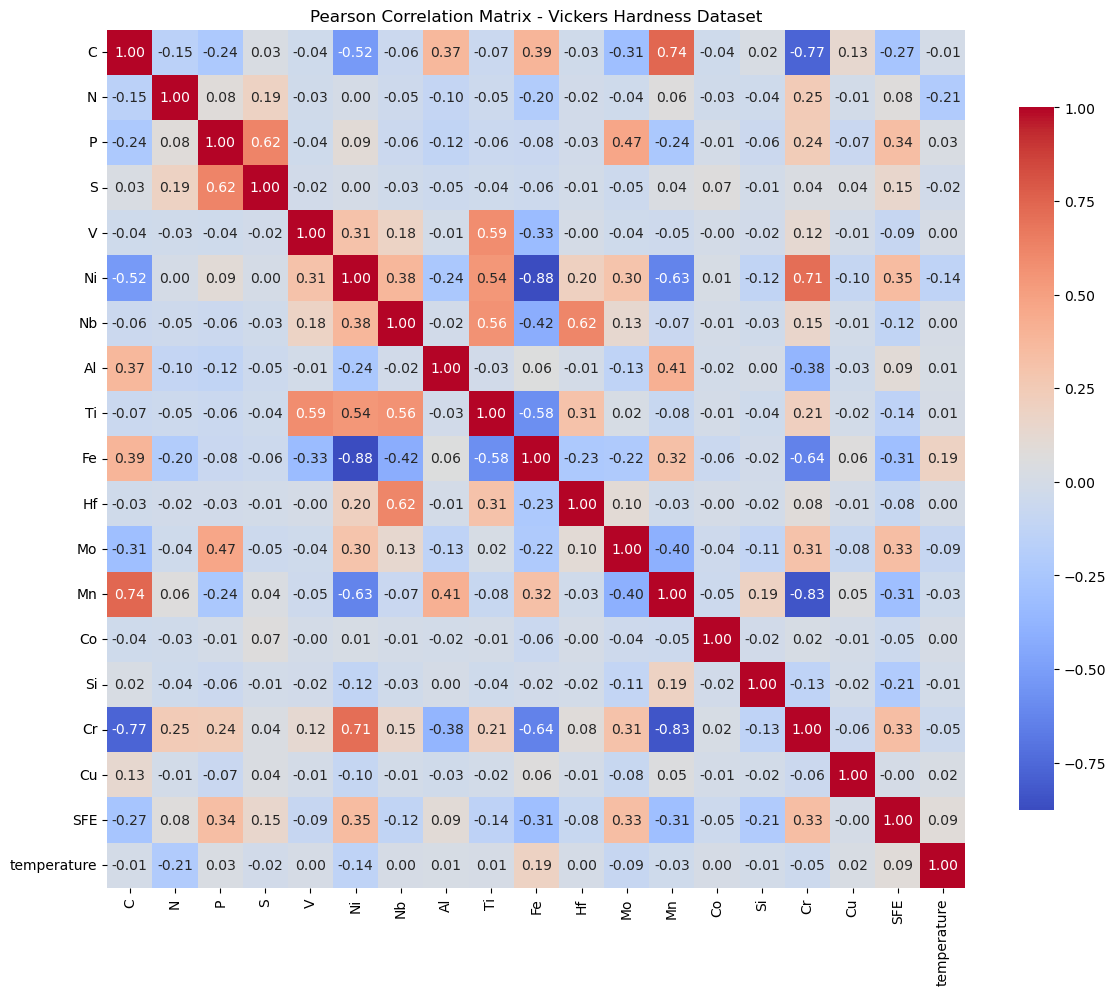

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (replace with the correct filename and path)
df = pd.read_csv('SFE_DATA_1.csv')

# Compute the Pearson correlation matrix
corr_matrix = df.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': 0.8})
plt.title('Pearson Correlation Matrix - Vickers Hardness Dataset')
plt.tight_layout()
plt.show()


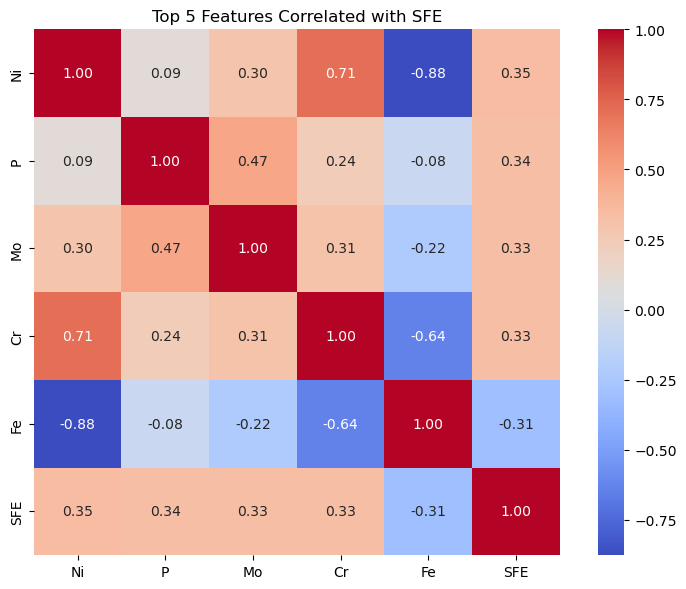

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('SFE_DATA_1.csv')

# Compute Pearson correlation matrix
corr_matrix = df.corr(method='pearson')

# Select the top 5 features most correlated with 'Vickers_Hardness' (excluding itself)
target_col = 'SFE'
top_features = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False).head(5).index.tolist()

# Add the target column back for sub-matrix
top_corr_features = top_features + [target_col]
top_corr_matrix = corr_matrix.loc[top_corr_features, top_corr_features]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(top_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title(f'Top 5 Features Correlated with {target_col}')
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform

# Load data
df = pd.read_csv("SFE_DATA_1.csv")

# Features & target
X = df.drop(columns=['SFE'])
y = df['SFE']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # You can also use 'median', 'most_frequent', etc.
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)



# -----------------------------------------
# Model Evaluation Function
# -----------------------------------------
def evaluate_model(model, name):
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    print(f"\n{name} Performance:")
    print(f"Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.4f}")
    print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
    print(f"Train R² Score: {r2_score(y_train, y_train_pred):.4f}")

    print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False):.4f}")
    print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
    print(f"Test R² Score: {r2_score(y_test, y_test_pred):.4f}")

# -----------------------------------------
# Random Search Function
# -----------------------------------------
def run_random_search(model, param_grid, name):
    search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=50,
                                cv=5, verbose=1, random_state=42, n_jobs=-1, scoring='neg_root_mean_squared_error')
    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_

    print(f"\n{name} Best Parameters: {search.best_params_}")
    evaluate_model(best_model, name)
    return best_model, search.best_params_

# -----------------------------------------
# Hyperparameter Grids
# -----------------------------------------
svr_params = {
    'C': uniform(0.1, 10),
    'epsilon': uniform(0.01, 1),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

dt_params = {
    'max_depth': randint(2, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

et_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

knn_params = {
    'n_neighbors': randint(2, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan and Euclidean
}

gbr_params = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 20),
    'subsample': uniform(0.6, 0.4),
    'min_samples_split': randint(2, 20)
}

hgb_params = {
    'learning_rate': uniform(0.01, 0.3),
    'max_iter': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_leaf': randint(1, 20)
}

kr_params = {
    'alpha': uniform(0.01, 1.0),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# -----------------------------------------
# Run All Models
# -----------------------------------------

# 1. Linear Regression (No hyperparameters)
evaluate_model(LinearRegression(), "Linear Regression")

# 2. SVR
svr_model, svr_best_params = run_random_search(SVR(), svr_params, "Support Vector Regressor")

# 3. Decision Tree
dt_model, dt_best_params = run_random_search(DecisionTreeRegressor(random_state=42), dt_params, "Decision Tree Regressor")

# 4. Random Forest
rf_model, rf_best_params = run_random_search(RandomForestRegressor(random_state=42), rf_params, "Random Forest Regressor")

# 5. Extra Trees
et_model, et_best_params = run_random_search(ExtraTreesRegressor(random_state=42), et_params, "Extra Trees Regressor")

# 6. KNN
knn_model, knn_best_params = run_random_search(KNeighborsRegressor(), knn_params, "KNN Regressor")

# 7. Gradient Boosting
gbr_model, gbr_best_params = run_random_search(GradientBoostingRegressor(random_state=42), gbr_params, "Gradient Boosting Regressor")

# 8. Hist Gradient Boosting
hgb_model, hgb_best_params = run_random_search(HistGradientBoostingRegressor(random_state=42), hgb_params, "Hist Gradient Boosting Regressor")

# 9. Kernel Ridge (uncomment if needed)
# kr_model, kr_best_params = run_random_search(KernelRidge(), kr_params, "Kernel Ridge Regressor")

# -----------------------------------------
# Print Stored Best Hyperparameters
# -----------------------------------------
print("\n\n===== Stored Best Hyperparameters by Variable =====")
print("SVR:", svr_best_params)
print("Decision Tree:", dt_best_params)
print("Random Forest:", rf_best_params)
print("Extra Trees:", et_best_params)
print("KNN:", knn_best_params)
print("Gradient Boosting:", gbr_best_params)
print("Hist Gradient Boosting:", hgb_best_params)
# print("Kernel Ridge:", kr_best_params)



Linear Regression Performance:
Train RMSE: 10.7030
Train MSE: 114.5535
Train R² Score: 0.5664
Test RMSE: 16.1904
Test MSE: 262.1286
Test R² Score: 0.0392
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Support Vector Regressor Best Parameters: {'C': 8.932802589188682, 'epsilon': 0.33434502100527397, 'gamma': 'scale', 'kernel': 'rbf'}

Support Vector Regressor Performance:
Train RMSE: 9.5788
Train MSE: 91.7540
Train R² Score: 0.6527
Test RMSE: 9.8379
Test MSE: 96.7849
Test R² Score: 0.6453
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Decision Tree Regressor Best Parameters: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2}

Decision Tree Regressor Performance:
Train RMSE: 5.9823
Train MSE: 35.7880
Train R² Score: 0.8645
Test RMSE: 9.4314
Test MSE: 88.9512
Test R² Score: 0.6740
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Random Forest Regressor Best Parameters: {'max_depth': 37, 'min_samples_leaf': 1, 'min_samples_split':

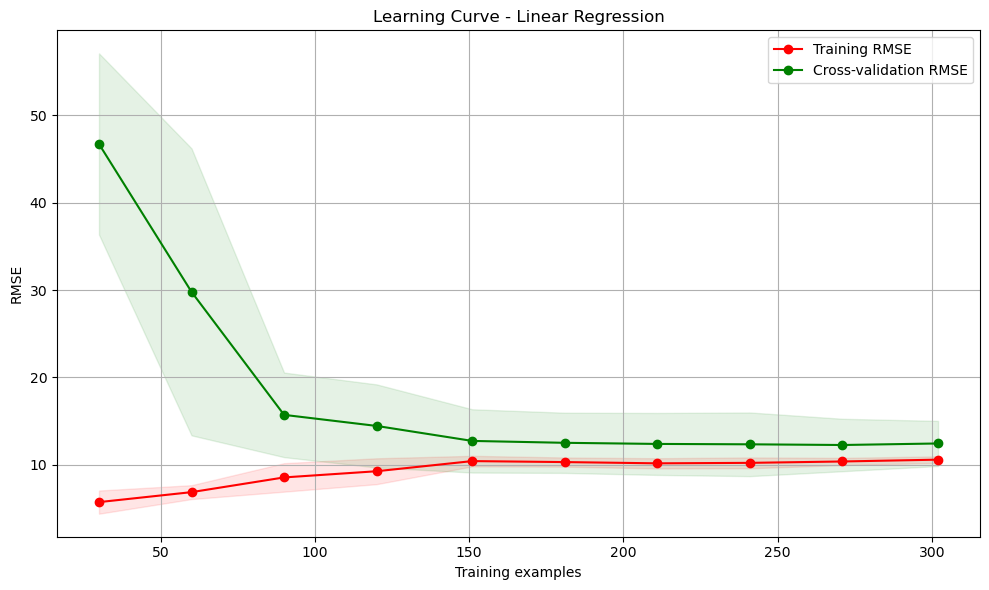

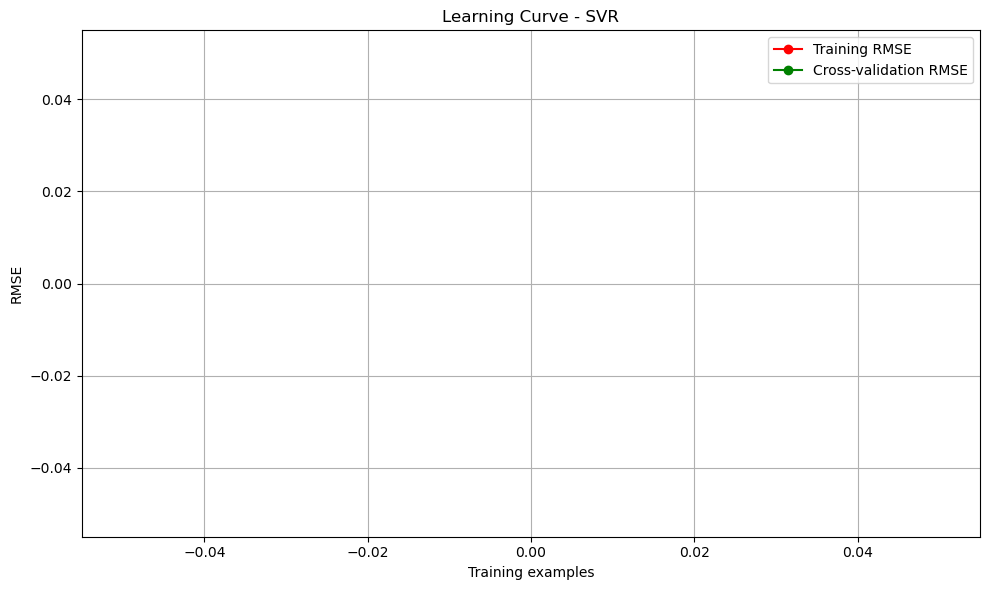

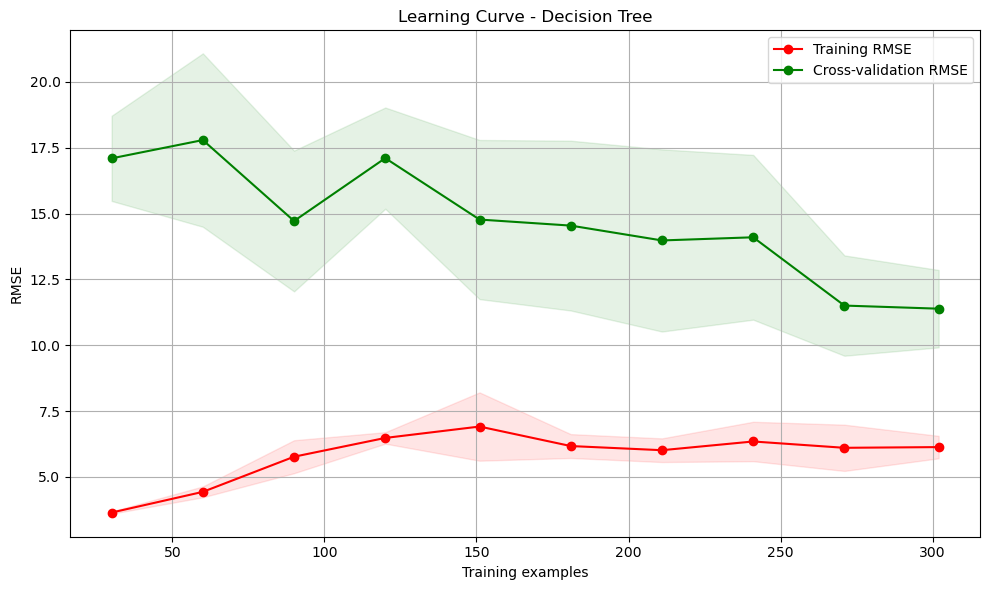

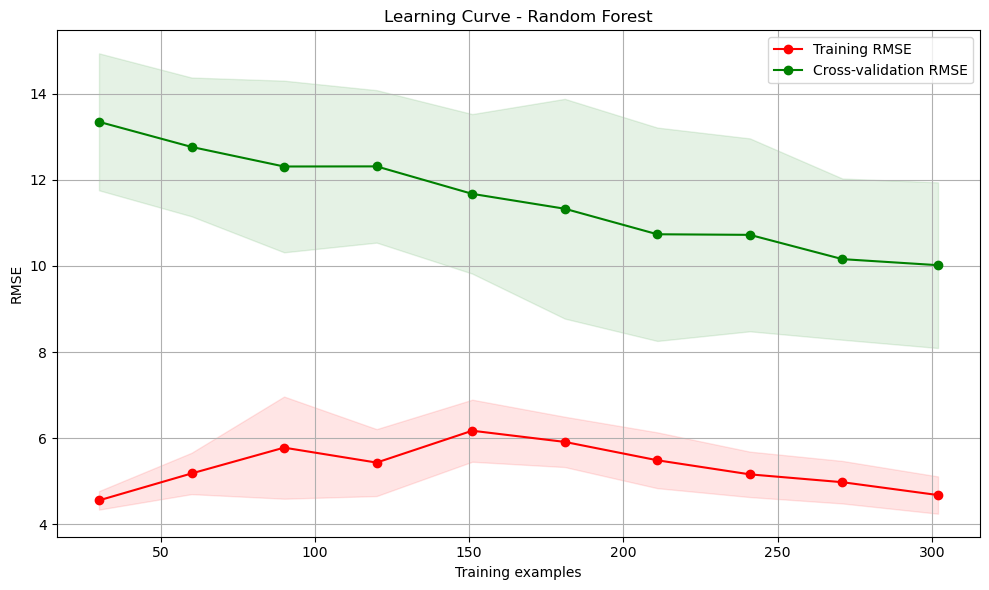

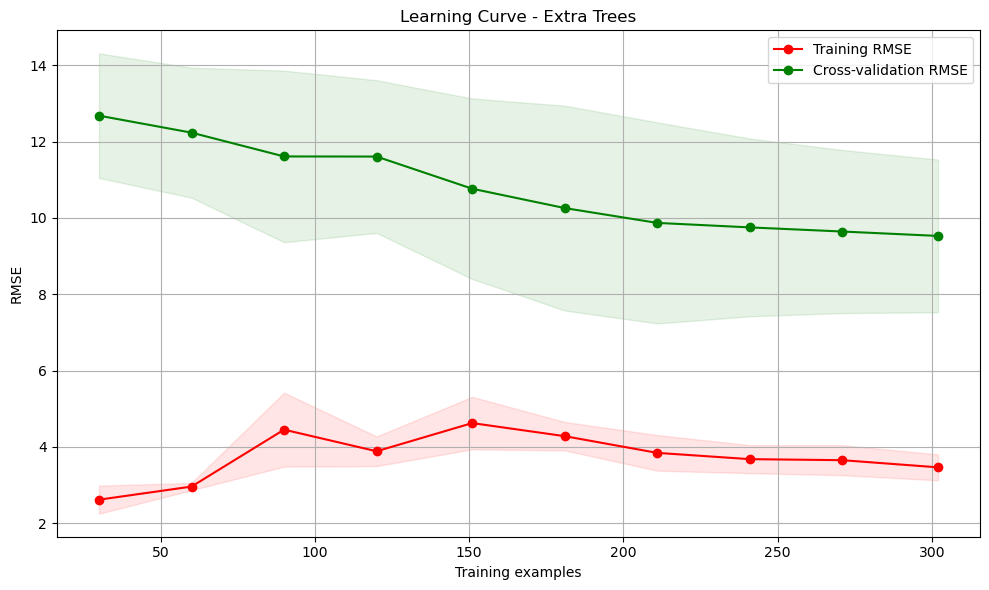

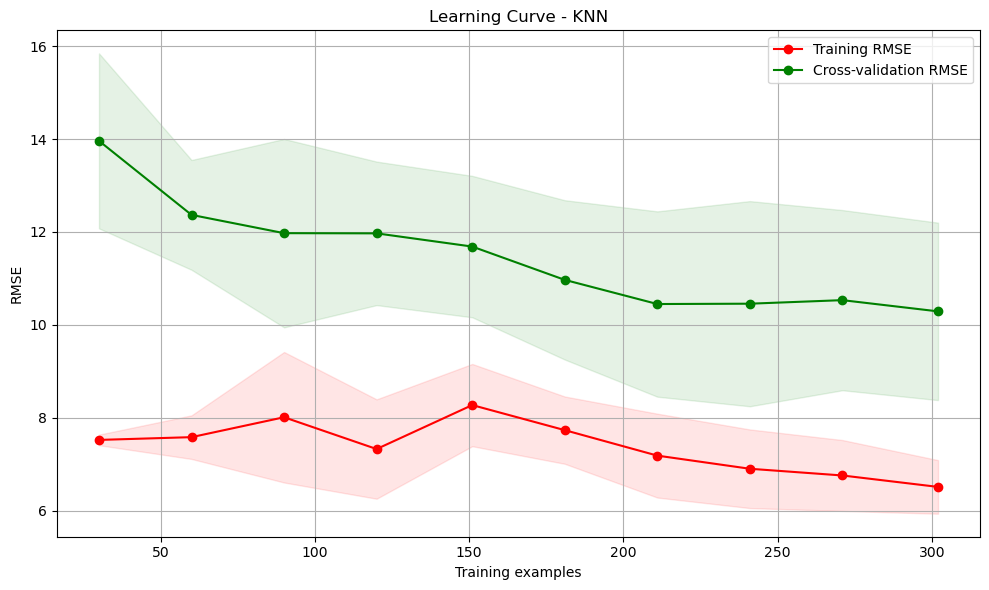

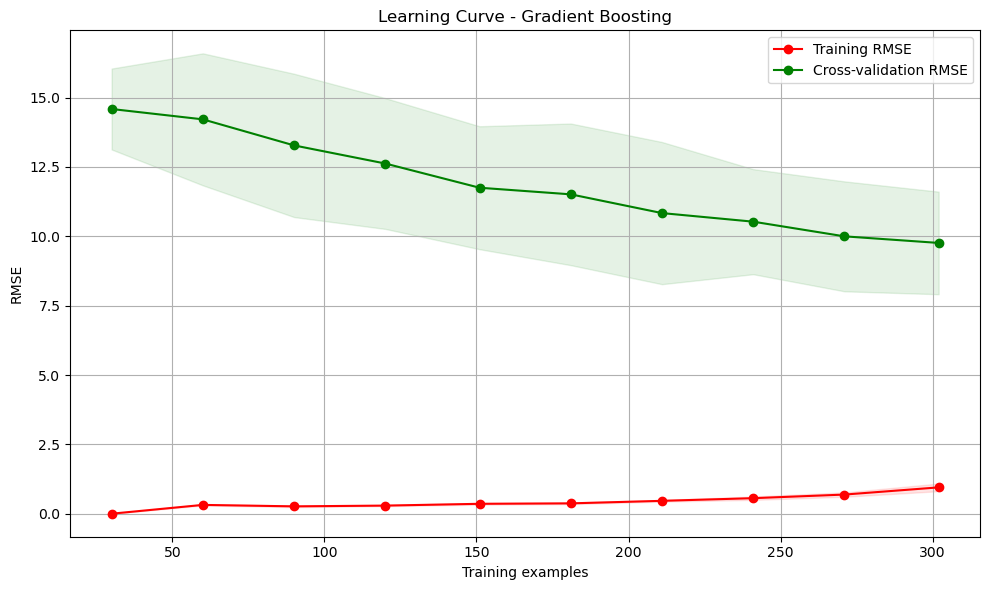

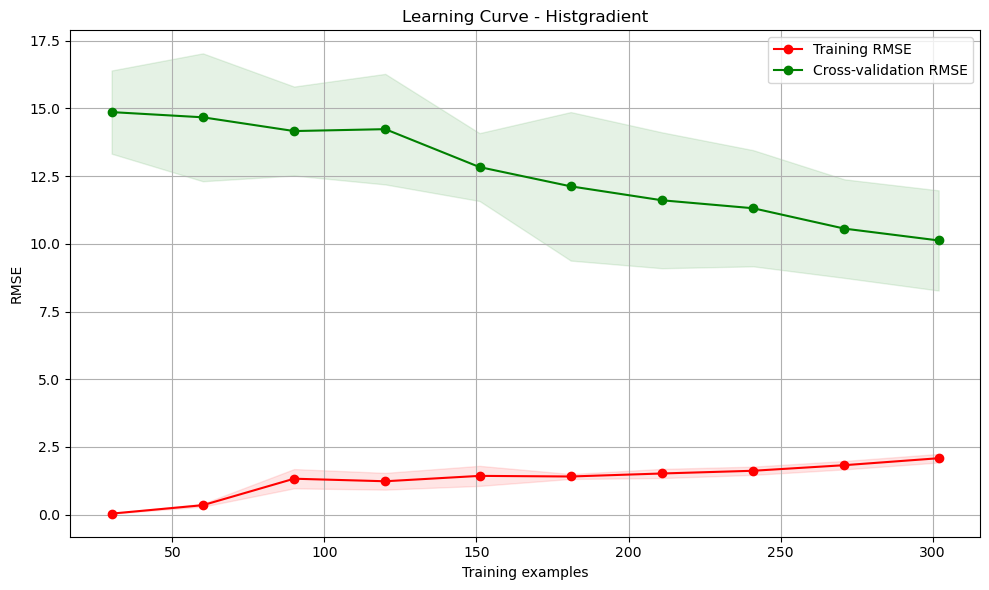

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Define your custom plot function with RMSE
def plot_learning_curve(model, X, y, model_name="Model", cv=5, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)):
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )

    # Convert negative RMSE to positive
    train_mean = -np.mean(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training RMSE")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")

    plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation RMSE")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")

    plt.title(f"Learning Curve - {model_name}")
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define models (make sure *_params are already defined before this block)
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(**svr_params),
    "Decision Tree": DecisionTreeRegressor(**dt_best_params),
    "Random Forest": RandomForestRegressor(**rf_best_params),
    "Extra Trees": ExtraTreesRegressor(**et_best_params),
    "KNN": KNeighborsRegressor(**knn_best_params),
    "Gradient Boosting": GradientBoostingRegressor(**gbr_best_params),
    "Histgradient": HistGradientBoostingRegressor(**hgb_best_params),
}

# Plot learning curve for each model using RMSE
for name, model in models.items():
    plot_learning_curve(model, X_train_scaled, y_train, model_name=name, scoring='neg_root_mean_squared_error')
